In [1]:

library(ggplot2)
library(ggrepel)
library(here)
readRenviron(here("config.env"))
resultsdir <- Sys.getenv("resultsdir")

here() starts at /users/home/ghemani/repo/rhds2026



In [2]:
combined.filename <- file.path(resultsdir, "combined-clin-pred-proteins.txt")
data <- read.table(combined.filename,
  header = T, sep = "\t", stringsAsFactors = F
)

protein.names <-
  subset(
    meffonym::meffonym.models(full = T),
    grepl("^episcores", filename)
  )$name
protein.names <- make.names(protein.names)

table(protein.names %in% colnames(data))

formulae <- sapply(protein.names, function(i) {
  reformulate(i, response = "tumor")
}, simplify = F)

# run glms
fit <- sapply(formulae, function(i) {
  glm(i, data = data, family = binomial())
}, simplify = F)

fit.summary <- sapply(fit, function(i) {
  out <- summary(i)$coefficients
  out[, "Estimate"] <- out[, "Estimate"]
  out
}, simplify = F)

fit.coefs <- sapply(fit.summary, function(i) {
  i[2, c("Estimate", "Pr(>|z|)")]
}, simplify = F)
fit.coefs <- {
  x <- do.call(rbind, fit.coefs)
  data.frame(
    pred.protein = rownames(x),
    coef = x[, "Estimate"],
    p.value = x[, "Pr(>|z|)"]
  )
}

bonferroni <- -log10(0.05 / length(fit))

loading models ...
Sun Jan 11 13:11:57 2026 Adding model:  wid-smk-distal-epithelial-hyperM 
Sun Jan 11 13:11:57 2026 Adding model:  wid-smk-immune-hypoM 
Sun Jan 11 13:11:57 2026 Adding model:  wid-smk-epithelial-hypoM 
Sun Jan 11 13:11:57 2026 Adding model:  wid-smk-proximal-epithelial-hyperM 
Sun Jan 11 13:11:57 2026 Adding model:  wahl-bmi-european 
Sun Jan 11 13:11:57 2026 Adding model:  wahl-bmi-indian 
Sun Jan 11 13:11:57 2026 Adding model:  wahl-bmi 
Sun Jan 11 13:11:57 2026 Adding model:  gs-cognitive 
Sun Jan 11 13:11:57 2026 Adding model:  patella-lead 
Sun Jan 11 13:11:57 2026 Adding model:  tibia-lead 
Sun Jan 11 13:11:57 2026 Adding model:  cmv 
Sun Jan 11 13:11:57 2026 Adding model:  epismoker-current 
Sun Jan 11 13:11:57 2026 Adding model:  epismoker-former 
Sun Jan 11 13:11:57 2026 Adding model:  epismoker-never 
Sun Jan 11 13:11:57 2026 Adding model:  elliott-smoking 
Sun Jan 11 13:11:57 2026 Adding model:  zhang-smoking 
Sun Jan 11 13:11:57 2026 Adding model:  do.bmi


TRUE 
 109 

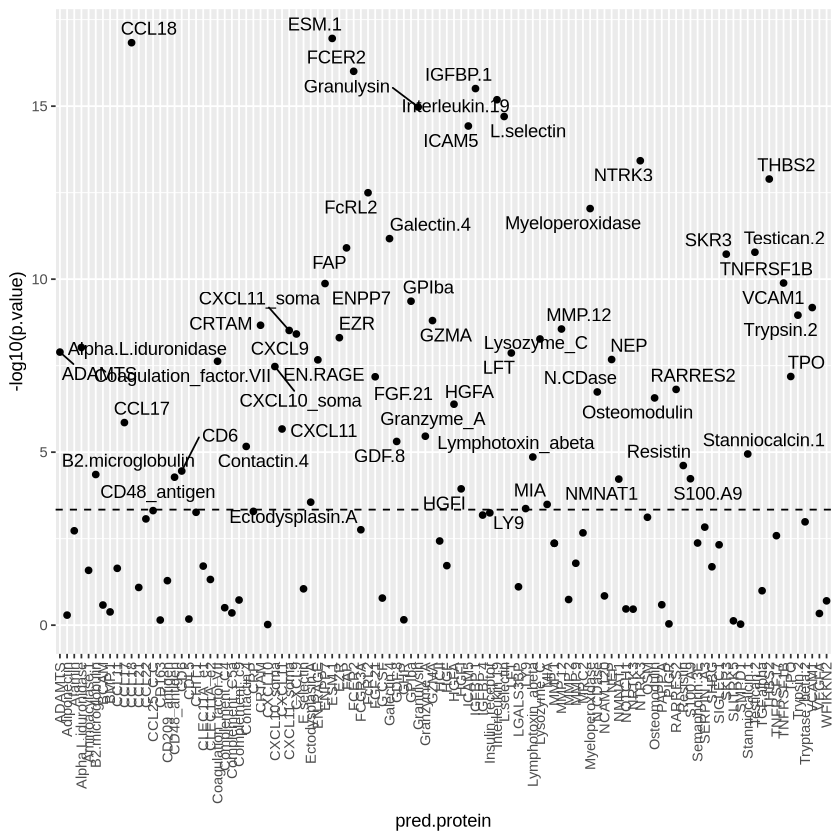

In [3]:
fit.coefs |>
  ggplot(aes(x = pred.protein, y = -log10(p.value))) +
  geom_point() +
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1)) +
  geom_text_repel(
    data = fit.coefs[which((-log10(fit.coefs$p.value) > bonferroni)), ],
    aes(x = pred.protein, y = -log10(p.value), label = pred.protein)
  ) +
  geom_hline(
    yintercept = bonferroni,
    linetype = "dashed"
  )
